Thank you to Cameron Davidson-Pilon, as I added a few alterations, but most of the content and code was taken from his book robabilistic-Programming-and-Bayesian-Methods-for-Hackers

In [1]:
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats

C:\Users\adam\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Assume that there is some true 0<pA<1 probability that users who, upon shown site A, eventually purchase from the site. The observed pA is not the true pA, but we can infer the true pA from the prior and obseved pA. 
* We are interested in using what we know, N (the total trials administered) and n (the number of conversions/people that purched), to estimate what pA, the true frequency of buyers, might be. 

To do all this, we will calculate: 
* P(true_pA | observed_pA) = P(obsrvd_pA | true_pA)*P(true_pA)

**P(true_pA)**

In [101]:
"""The PRIOR"""   #----------- P(true_pA)
# The parameters are the bounds of the Uniform because we assume an equal probability across all possible values:
# the probability that 1% of users would purchase is the same as 10% or 34% or 92%, etc.
with pm.Model() as model:
    p = pm.Uniform('p', lower=0, upper=1)

Sample distribution of P(true_pA)

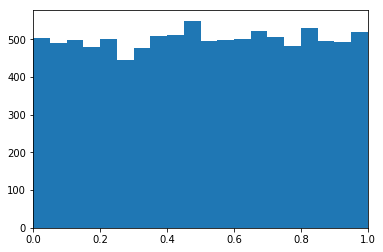

In [3]:
samples1 = [p.random() for i in range(10000)]
plt.hist(samples1, bins=20)
plt.xlim(0,1)
plt.show()

**Obsrvd_pA**

In [102]:
# simulate generation of observed data as if we run the experiment with the users

p_true = 0.1   # remember, this is unknown. This is just to generate the data
N = 150        # Number of users shown site A

# sample N Bernoulli random variables from Ber(0.05).
# each random variable has a 0.05 chance of being a 1.
# this is the data-generation step
occurrences = stats.bernoulli.rvs(p_true, size=N) # obsrvd_pA: number of users that purchased product in site A

# print(occurrences) # Remember: Python treats True == 1, and False == 0
print(np.sum(occurrences), 'from 150 users that were shown site A purched a product')

14 from 150 users that were shown site A purched a product


In [103]:
# Occurrences.mean is equal to n/N.
print("What is the observed frenquency in Group A? %.4f" % np.mean(occurrences))
print("Does this equal the true frequency? %s" % (np.mean(occurrences) == p_true))

What is the observed frenquency in Group A? 0.0933
Does this equal the true frequency? False


**P(obsrvd_pA|true_pA)**

In [104]:
"""The Likelihood""" #---------- P(obsrvd_pA|true_pA)
# include the observations, which are Bernoulli
with model:
    obs = pm.Bernoulli("obs", p, observed=occurrences)

**P(true_pA | observed_pA)**

In [105]:
with model:   
    step = pm.Metropolis()
    trace = pm.sample(18000, step=step)
    burned_trace = trace[1000:]

Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [p_interval__]
The number of effective samples is smaller than 25% for some parameters.


**For 150 Users**

In [106]:
#for N=150
print("The observed frenquency in Group A: %.8f" % np.mean(occurrences))
print("The posterior frenquency in Group A, based on the observed data and prior(true_pA is): {}"\
      .format(round(np.mean(burned_trace['p']),6)))
print('Difference between observed frequency and posterior frequency: {}'.format(np.mean(burned_trace['p'])-np.mean(occurrences)))
print('Percentage increase from observed to posterior frequncy: {}'.format((np.mean(burned_trace['p'])-np.mean(occurrences))/
                                                                           np.mean(occurrences)))
pm.summary(burned_trace)

The observed frenquency in Group A: 0.09333333
The posterior frenquency in Group A, based on the observed data and prior(true_pA is): 0.098536
Difference between observed frequency and posterior frequency: 0.0052030679814718955
Percentage increase from observed to posterior frequncy: 0.055747156944341736


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
p,0.098536,0.024269,0.000303,0.055302,0.147776,6875.730396,1.00006


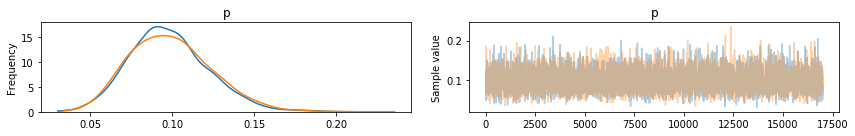

In [107]:
#150
pm.traceplot(burned_trace)
plt.show()

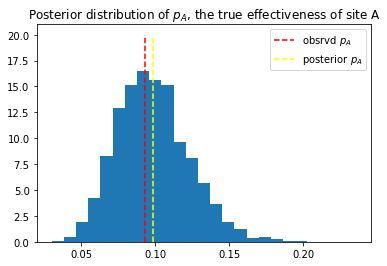

In [110]:
#for N=150
plt.title("Posterior distribution of $p_A$, the true effectiveness of site A")
# plt.vlines(p_true, 0, 90, linestyle="--", label="true $p_A$ (unknown)")
plt.vlines(np.mean(occurrences), 0, 20, linestyle="--", label="obsrvd $p_A$", color='red')
plt.vlines(np.mean(burned_trace["p"]), 0, 20, linestyle="--", label="posterior $p_A$", color='yellow')
plt.hist(burned_trace["p"], bins=25, histtype="stepfilled", normed=True)
plt.legend()
plt.show()

Now, let's compare this posterior and mean with generated data on 750 users.

**For 750 Users**

In [93]:
# simulate generation of observed data as if we run the experiment with the users

p_true = 0.1   # remember, this is unknown. This is just to generate the data
N = 750        # Number of users shown site A

# sample N Bernoulli random variables from Ber(0.05).
# each random variable has a 0.05 chance of being a 1.
# this is the data-generation step
occurrences = stats.bernoulli.rvs(p_true, size=N) # obsrvd_pA: number of users that purchased product in site A

# print(occurrences) # Remember: Python treats True == 1, and False == 0
print(np.sum(occurrences), 'from 150 users that were shown site A purched a product')
print("What is the observed frenquency in Group A? %.4f" % np.mean(occurrences))

82 from 150 users that were shown site A purched a product
What is the observed frenquency in Group A? 0.1093


In [94]:
with pm.Model() as model:
    p = pm.Uniform('p', lower=0, upper=1)
    obs = pm.Bernoulli("obs", p, observed=occurrences)
    step = pm.Metropolis()
    trace = pm.sample(18000, step=step)
    burned_trace = trace[1000:]

Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [p_interval__]
The number of effective samples is smaller than 25% for some parameters.


In [95]:
#for N=750
print("The observed frenquency in Group A: %.8f" % np.mean(occurrences))
print("The posterior frenquency in Group A, based on the observed data and prior(true_pA is): {}"\
      .format(round(np.mean(burned_trace['p']),6)))
print('Difference between observed frequency and posterior frequency: {}'.format(np.mean(burned_trace['p'])-np.mean(occurrences)))
print('Percentage increase from observed to posterior frequncy: {}'.format((np.mean(burned_trace['p'])-np.mean(occurrences))/
                                                                           np.mean(occurrences)))
pm.summary(burned_trace)

The observed frenquency in Group A: 0.10933333
The posterior frenquency in Group A, based on the observed data and prior(true_pA is): 0.110057
Difference between observed frequency and posterior frequency: 0.0007237884559261193
Percentage increase from observed to posterior frequncy: 0.00662001636517792


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
p,0.110057,0.011523,0.00018,0.086754,0.132254,4382.380419,1.00082


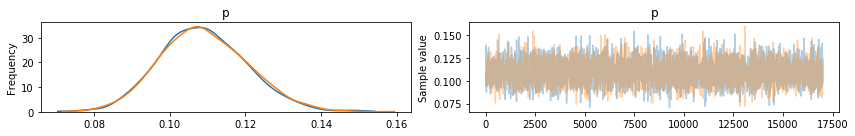

In [49]:
#750
pm.traceplot(burned_trace)
plt.show()

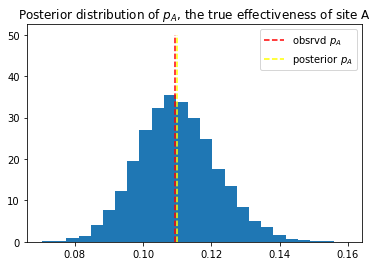

In [98]:
#for N=750
plt.title("Posterior distribution of $p_A$, the true effectiveness of site A")
# plt.vlines(p_true, 0, 90, linestyle="--", label="true $p_A$ (unknown)")
plt.vlines(np.mean(occurrences), 0, 50, linestyle="--", label="obsrvd $p_A$", color='red')
plt.vlines(np.mean(burned_trace["p"]), 0, 50, linestyle="--", label="posterior $p_A$", color='yellow')
plt.hist(burned_trace["p"], bins=25, histtype="stepfilled", normed=True)
plt.legend()
plt.show()

Now, let's compare this posterior and mean with generated data on 1500 users.

**For 1500 Users**

In [115]:
# simulate generation of observed data as if we run the experiment with the users

p_true = 0.1   # remember, this is unknown. This is just to generate the data
N = 1500        # Number of users shown site A

# sample N Bernoulli random variables from Ber(0.05).
# each random variable has a 0.05 chance of being a 1.
# this is the data-generation step
occurrences = stats.bernoulli.rvs(p_true, size=N) # obsrvd_pA: number of users that purchased product in site A

# print(occurrences) # Remember: Python treats True == 1, and False == 0
print(np.sum(occurrences), 'from 150 users that were shown site A purched a product')
print("What is the observed frenquency in Group A? %.4f" % np.mean(occurrences))

153 from 150 users that were shown site A purched a product
What is the observed frenquency in Group A? 0.1020


In [116]:
with pm.Model() as model:
    p = pm.Uniform('p', lower=0, upper=1)
    obs = pm.Bernoulli("obs", p, observed=occurrences)
    step = pm.Metropolis()
    trace = pm.sample(18000, step=step)
    burned_trace = trace[1000:]

Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [p_interval__]
The number of effective samples is smaller than 25% for some parameters.


In [118]:
#for N=1500
print("The observed frenquency in Group A: %.8f" % np.mean(occurrences))
print("The posterior frenquency in Group A, based on the observed data and prior(true_pA is): {}"\
      .format(round(np.mean(burned_trace['p']),6)))
print('Difference between observed frequency and posterior frequency: {}'.format(np.mean(burned_trace['p'])-np.mean(occurrences)))
print('Percentage increase from observed to posterior frequncy: {}'.format((np.mean(burned_trace['p'])-np.mean(occurrences))/
                                                                           np.mean(occurrences)))
pm.summary(burned_trace)


The observed frenquency in Group A: 0.10200000
The posterior frenquency in Group A, based on the observed data and prior(true_pA is): 0.10253
Difference between observed frequency and posterior frequency: 0.0005304713379749443
Percentage increase from observed to posterior frequncy: 0.005200699391911218


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
p,0.10253,0.007833,0.000122,0.087238,0.117765,3805.576539,1.000943


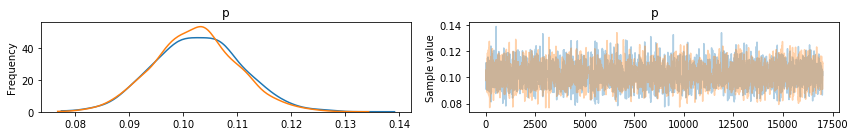

In [119]:
#1550
pm.traceplot(burned_trace)
plt.show()

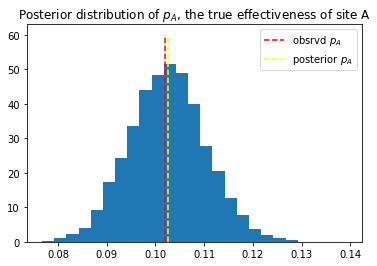

In [120]:
#for N=1500
plt.title("Posterior distribution of $p_A$, the true effectiveness of site A")
# plt.vlines(p_true, 0, 90, linestyle="--", label="true $p_A$ (unknown)")
plt.vlines(np.mean(occurrences), 0, 60, linestyle="--", label="obsrvd $p_A$", color='red')
plt.vlines(np.mean(burned_trace["p"]), 0, 60, linestyle="--", label="posterior $p_A$", color='yellow')
plt.hist(burned_trace["p"], bins=25, histtype="stepfilled", normed=True)
plt.legend()
plt.show()

A few conclusions when comparing the posterior of experiments for 150, 750, and 1500 users:
* The higher the N (more users), the closer we are to the 'true' mean, or std, etc, because there is less uncertainty. As a result, the percentage change b/w the observed to posterior frequency is smaller, the higher the N.
* Given that we chose a uniform distribution for p, the expected value of a uniform distributioin is 0.5(a+b), meaning 0.5(0+1)=0.5; As a result, the posterior will always pull the observed mean closer to 0.5. For example, if observed mean is 0.2, its posterior will always be higher. if its 0.7, its posterior will always be lower.

# A and B together

A similar anaylsis can be done for site B's response data to determine the analogous pB. But what we are really interested in is the difference between pA and pB. Let's infer pA, pB, and delta=pA−pB, all at once. We can do this using PyMC3's deterministic variables. 

(We'll assume for this exercise that pB=0.13, pB=0.14, so delta=0.01, and NB=750 while NA=1500)

In [145]:
np.random.seed(2004075)

#these two quantities are unknown to us.
true_p_A = 0.13
true_p_B = 0.14

#notice the unequal sample sizes -- no problem in Bayesian analysis.
N_A = 1500 # number of users shown site A
N_B = 150  # number of users shown site B

#generate some observations
observations_A = stats.bernoulli.rvs(true_p_A, size=N_A)
observations_B = stats.bernoulli.rvs(true_p_B, size=N_B)
print("Obs from Site A: ", observations_A[:30], "...")
print("Obs from Site B: ", observations_B[:30], "...")
print("The observed frenquency in Group A: %.4f" % np.mean(observations_A))
print("The observed frenquency in Group B is slighter lower than A: %.4f" % np.mean(observations_B))


Obs from Site A:  [0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0] ...
Obs from Site B:  [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0] ...
The observed frenquency in Group A: 0.1220
The observed frenquency in Group B is slighter lower than A: 0.1200


In [146]:
# Set up the pymc3 model. Again assume Uniform priors for p_A and p_B.
with pm.Model() as model:
    p_A = pm.Uniform("p_A", 0, 1)
    p_B = pm.Uniform("p_B", 0, 1)
    
    # Define the deterministic delta function. This is our unknown of interest.
    delta = pm.Deterministic("delta", p_A - p_B)

    
    # Set of observations, in this case we have two observation datasets.
    obs_A = pm.Bernoulli("obs_A", p_A, observed=observations_A)
    obs_B = pm.Bernoulli("obs_B", p_B, observed=observations_B)

    # To be explained in chapter 3.
    step = pm.Metropolis()
    trace = pm.sample(20000, step=step)
    burned_trace=trace[1000:]

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [p_B_interval__]
>Metropolis: [p_A_interval__]
The number of effective samples is smaller than 25% for some parameters.


In [147]:
p_A_samples = burned_trace["p_A"]
p_B_samples = burned_trace["p_B"]
delta_samples = burned_trace["delta"]

In [148]:
pm.summary(burned_trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
p_A,0.122494,0.008450,0.000130,0.106899,0.139760,4146.409923,1.000733
p_B,0.124712,0.026601,0.000317,0.074542,0.177842,6852.760871,0.999976
delta,-0.002218,0.027861,0.000347,-0.055690,0.052169,6652.863854,1.000021


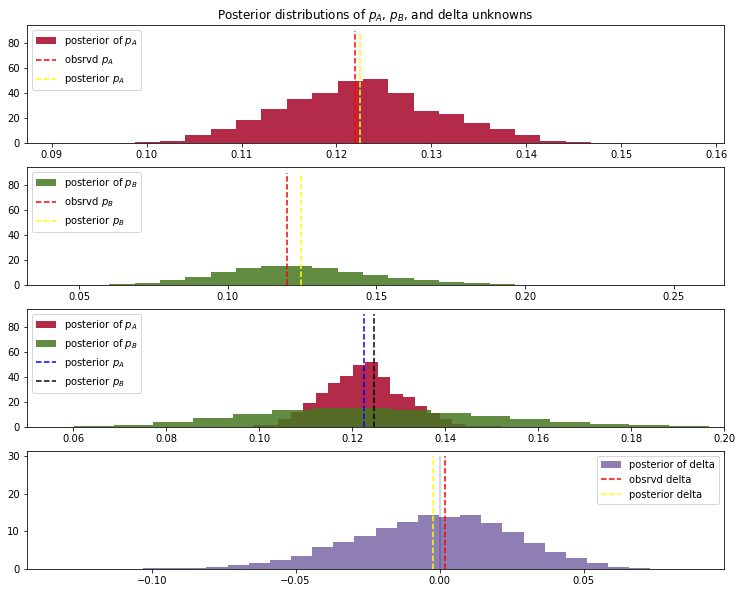

In [157]:
plt.figure(figsize=(12.5, 10))

ax = plt.subplot(411)

# plt.xlim(0.85, 0.999)
plt.hist(p_A_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_A$", color="#A60628", normed=True)
# plt.vlines(true_p_A, 0, 80, linestyle="--", label="true $p_A$ (unknown)")
plt.vlines(np.mean(observations_A), 0, 90, linestyle="--", label="obsrvd $p_A$", color='red')
plt.vlines(np.mean(p_A_samples), 0, 90, linestyle="--", label="posterior $p_A$", color='yellow')
plt.legend(loc="upper left")
plt.title("Posterior distributions of $p_A$, $p_B$, and delta unknowns")

ax = plt.subplot(412)

# plt.xlim(0.85, 0.999)
plt.hist(p_B_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_B$", color="#467821", normed=True)
# plt.vlines(true_p_B, 0, 80, linestyle="--", label="true $p_B$ (unknown)")
plt.vlines(np.mean(observations_B), 0, 90, linestyle="--", label="obsrvd $p_B$", color='red')
plt.vlines(np.mean(p_B_samples), 0, 90, linestyle="--", label="posterior $p_B$", color='yellow')

plt.legend(loc="upper left")

ax = plt.subplot(413)

plt.xlim(0.05, 0.2)
plt.hist(p_A_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_A$", color="#A60628", normed=True)
plt.hist(p_B_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_B$", color="#467821", normed=True)
plt.vlines(np.mean(p_A_samples), 0, 90, linestyle="--", label="posterior $p_A$", color='blue')
plt.vlines(np.mean(p_B_samples), 0, 90, linestyle="--", label="posterior $p_B$", color='black')
plt.legend(loc="upper left")


ax = plt.subplot(414)
plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of delta", color="#7A68A6", normed=True)
plt.vlines(np.mean(observations_A)-np.mean(observations_B), 0, 30, linestyle="--", label="obsrvd delta", color='red')
plt.vlines(np.mean(delta_samples), 0, 30, linestyle="--",
           label="posterior delta", color='yellow')
plt.vlines(0, 0, 30, color="black", alpha=0.2)
plt.legend(loc="upper right");
plt.show()

Given that pB has only 150 samples compared to 1500 for pA (we have less data from site B), our posterior distribution of pB is fatter, implying we are less certain about the true value of pB than we are of pA. Consequently, the posterior mean for pB will shift closer to 0.5 than the posterior mean for pA would.

With respect to the posterior distribution of delta, we can see that the about half of the distribution is above delta=0, implying that site A's response is very similar to site B's response. The probability this inference is incorrect is easily computable:

In [159]:
# Count the number of samples less than 0, i.e. the area under the curve
# before 0, represent the probability that site A is worse than site B.
print("For posterior p_A, %.5f"% np.mean(p_A_samples), ", posterior p_B, %.5f"% np.mean(p_B_samples),':')
print("Probability site A is WORSE than site B: %.2f" % \
    np.mean(delta_samples < 0))

print("Probability site A is BETTER than site B: %.2f" % \
    np.mean(delta_samples > 0))

For posterior p_A, 0.12249 , posterior p_B, 0.12471 :
Probability site A is WORSE than site B: 0.51
Probability site A is BETTER than site B: 0.49


**Although in observed data site A had a higher percentage of buyers, given that site B had a slightly lower percentage of buyers than A and a significantly smaller N, it is more like that site B is better**

# A few more stats

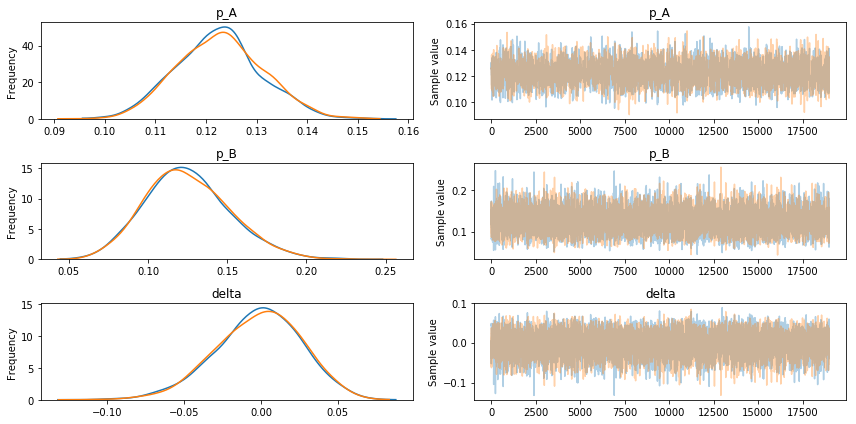

In [153]:
pm.traceplot(burned_trace)
plt.show()

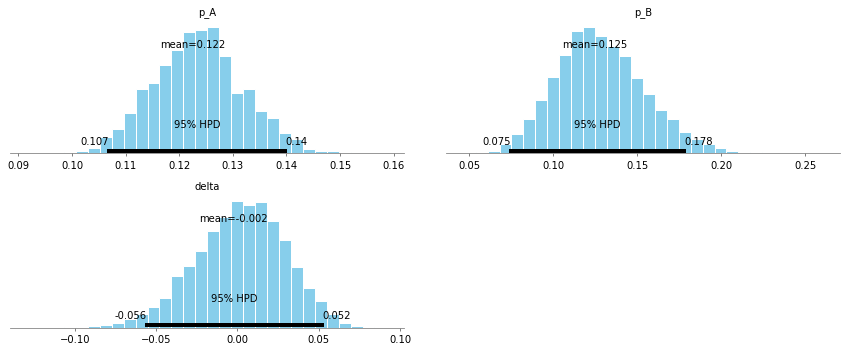

In [161]:
pm.plot_posterior(burned_trace, color='#87ceeb')
plt.show()

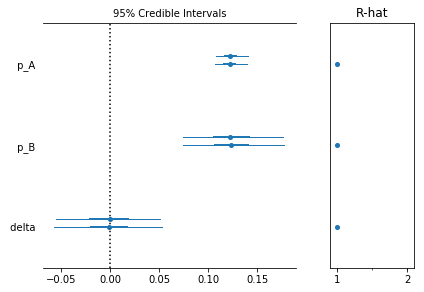

In [162]:
pm.forestplot(burned_trace)
plt.show()